In [1]:
# data visualiztion
import matplotlib.pyplot as plt
import seaborn as sns

# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# for linear regression models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
from statsmodels.formula.api import ols
import scipy.stats as stats

# recursive feature elimination (w/ cross validation), linear regression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

# Variance inflation factor, mean abs/squarred error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")

# make stuff look cooler
plt.style.use('fivethirtyeight')

In [2]:
# creates dictionary of variance inflation factors. 
def create_vif_dictionary(X):
    X = sm.add_constant(X)
    vif_dict = {}

    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    good_vifs = []
    bad_vifs = []

    for k,v in vif_dict.items():
        if v < 10:
            good_vifs.append(k)
        else:
            bad_vifs.append(k)

    return good_vifs,bad_vifs

# create a dictionary showing the adjusted R-squared values for each feature individually
def create_R2_dictionary(X,y):

    adj_R_squares = {}

    for feature in X.columns:
        predictors_int = sm.add_constant(X[feature])
        model = sm.OLS(y,predictors_int).fit()
        adj_R_square = float(model.summary2().tables[0][3][0])
        adj_R_squares[feature] = adj_R_square
        
    return adj_R_squares

# author's docstring is in a markup cell down below in the stepwise selection section
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)

    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            worst_feature_name = included[worst_feature]
            included.pop(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature_name, worst_pval))
        if not changed:
            break
    return included

# recursive feature elimination
def run_RFE(X,y):

    linreg = LinearRegression()
    selector = RFE(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass
    return selections, rankers

# recuersive feature elimination with cross validation
def run_RFECV(X,y):

    linreg = LinearRegression()
    selector = RFECV(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass

    return selections, rankers

# returns OLS linear regression model
def run_OLS_model(X,y):

    predictors_int = sm.add_constant(X)
    model = sm.OLS(y,predictors_int).fit()

    return model

# returns dictionary: keys are column labels, values are count of NaN values present
def create_NaN_dictionary(X):

    NaN_dict = {}

    for feature in X.columns:
        NaN_dict[feature] = sum(X[feature].isna())

    return NaN_dict



Set up predictor and target dataframes, deal with unusable data

In [3]:
X = pd.read_csv('data/kc_house_data.csv')
X.drop(X.loc[X['sqft_basement']=='?'].index,inplace=True) # remove '?' from the data.
y = X.price
y_log = np.log(y) # target vairable log transformed for normality
X.drop(['price','id','lat','long'],inplace=True,axis=1)

Engineer data to present as numerical values, not objects. 

In [4]:
# convert all string types into np floats
X.sqft_basement = [float(sq) for sq in list(X.sqft_basement)]

# Replaces grade strings with numerics based on data dict. 
grade_raws = list(X.grade.unique())
# replaces a cell value with the int of the first character of its existing string
for raw in grade_raws:
    X.grade.replace(to_replace=raw,value=int(raw[0]),inplace=True)

# replaces condition objects with numerics based on data dict.
condition_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
for key in condition_dict:
    X.condition.replace(to_replace=condition_dict,inplace=True)

# replace yr_built NaNs with numeric 0
X.yr_renovated.replace(to_replace=np.nan,value=0,inplace=True)

In [5]:
# convert waterfront into numeric boolean
waterfront_bool_list = []

for value in X.waterfront:
    if value == 'YES':
        waterfront_bool_list.append(1)
    else:
        waterfront_bool_list.append(0)
        
X.waterfront = waterfront_bool_list

In [6]:
# convert view from string into categorical ordinal
view_rank_list = [] 
view_dict = {'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}

for value in X.view:
    if value in list(view_dict.keys()):
        view_rank_list.append(view_dict[value])
    else:
        view_rank_list.append(0)
        
X.view = view_rank_list

Engineer date into a usable type of number (datetime ordinal)

In [7]:
# convert dates into ordinals
X.date = pd.to_datetime(X['date'])
X.date = X['date'].map(dt.datetime.toordinal)

In [8]:
nulls = create_NaN_dictionary(X)

Investigate multicolinearity before engineering inferred features

In [9]:
# funcitonize this ?? 

cor_df=X.corr().abs().stack().reset_index().sort_values(0, ascending=False)
cor_df['pairs'] = list(zip(cor_df.level_0, cor_df.level_1))
cor_df.set_index(['pairs'], inplace = True)
cor_df.drop(columns=['level_1', 'level_0'], inplace = True)
cor_df.columns = ['cc']
cor_df.drop_duplicates(inplace=True)

In [10]:
# cor_df[(cor_df.cc>.60) & (cor_df.cc <1)]

In [11]:
# colinear_drops = ['sqft_above','sqft_living15','bathrooms','sqft_lot15']

Engineering inferred feature
- bed bath ratio:           ratio of bedrooms to bathrooms
- level ratios:             ratio of square feet above 'grade' and below (ratio of everything else to the basement)
- live_lot_ratio:           ratio of living space to lot size
- relative living space:    ratio of living space to the living space of the nearest 15 houses (sqft_living :: sqft_living15)
- relatve lot size:         same as living space but for lot size instead. 
- level difference:         difference in square footage of living space to basement space

In [12]:
bbratios = []
lvl_ratios = []
live_lot_ratio = []

for index,row in X.iterrows(): #iterate through every record

    bbratio = row.bedrooms/row.bathrooms # calculate ratio of bedrooms to bathrooms
    bbratios.append(bbratio) # append ratio to the list

    LLratio = row.sqft_living/row.sqft_lot
    live_lot_ratio.append(LLratio)

    if row.sqft_basement == 0: # sqft_basement is zero if there is no basement
        lvl_ratios.append(0) # ratio should also be zero if there is no ratio
        
    else:
        lvl_ratio = row.sqft_above / row.sqft_basement # calculate ratio of space above grade vs below grade
        lvl_ratios.append(lvl_ratio) # append ratio to the list

X['bed_bath_ratio'] = bbratios # create new column and asign list as its values
X['level_ratio'] = lvl_ratios # create new column and asign list as its values
X['live_lot_ratio'] = live_lot_ratio # you get the idea . . . 

In [13]:
rel_live_space = []
rel_lot_size = [] 
rel_difference = []

for index,row in X.iterrows(): # for every record 
    live_dif = row.sqft_living - row.sqft_living15 # calculate difference in sqft of the given house and the nearest 15 other houses
    rel_live_space.append(live_dif) # append it to the list

    lot_dif = row.sqft_lot - row.sqft_lot15 # calculate difference in sqft of the given lot and the nearest 15 other lots
    rel_lot_size.append(lot_dif) # append it to the list

    lvl_dif = row.sqft_above - row.sqft_basement # calculate difference between space above grade and below grade
    rel_difference.append(lvl_dif) # append it to the list

X['relative_living_space'] = rel_live_space # assign respective list to new column 
X['relative_lot_size'] = rel_lot_size
X['level_difference'] = rel_difference

In [14]:
water_loc_dict = {'Duwamish':[98168],
'Elliott Bay':[98119,98104,98129,98132,98127,98125,98195,98101,98134,98170,98139,98131,98181], 
'Puget Sound':[98071,98083,98013,98070,98031,98131,98063,98195,98207,98190], 
'Lake Union':[98109], 
'Ship Canal':[00000], 
'Lake Washington':[98072,98077], 
'Lake Sammamish':[98074,98075,98029], 
'other lake':[00000], 
'river/slough waterfronts':[00000]}

waterfront_list = []

for zipcode in X.zipcode:
    for k,v in water_loc_dict.items():
        if zipcode in v:
            waterfront_list.append(k)
            appended = True
            break
        else: 
            appended = False
    if not appended:
        waterfront_list.append('NONE')

# print(len(waterfront_list),set(waterfront_list))
X['waterfront_loc'] = waterfront_list

In [15]:
waterfront_dummies = pd.get_dummies(X.waterfront_loc).drop('NONE',axis=1).add_prefix('waterfront_')

X = X.drop(['waterfront_loc','zipcode'],axis=1)
hot_water = pd.concat([X,waterfront_dummies],axis=1)

In [16]:
# hot_water.info()

In [17]:
cor_df=hot_water.corr().abs().stack().reset_index().sort_values(0, ascending=False)
cor_df['pairs'] = list(zip(cor_df.level_0, cor_df.level_1))
cor_df.set_index(['pairs'], inplace = True)
cor_df.drop(columns=['level_1', 'level_0'], inplace = True)
cor_df.columns = ['cc']
cor_df.drop_duplicates(inplace=True)

In [18]:
cor_df[(cor_df.cc>.60) & (cor_df.cc <1)]

# is it a good decision to drop sqft_living in lieu of relative_living_space ???

,cc
pairs,
"(level_difference, sqft_above)",0.887606
"(sqft_above, sqft_living)",0.876678
"(sqft_living15, sqft_living)",0.756389
"(sqft_living, bathrooms)",0.755278
"(sqft_lot, relative_lot_size)",0.754121
"(sqft_living15, sqft_above)",0.731016
"(sqft_lot15, sqft_lot)",0.720649
"(sqft_above, bathrooms)",0.686456
"(relative_living_space, sqft_living)",0.665513


In [19]:
# columns to drop based one colinearity
co_drops = ['sqft_living','sqft_above','sqft_living15','bathrooms','sqft_lot15','sqft_lot']  #at least one from each pair, most frequents chosen first

In [20]:
X_hot = hot_water.drop(co_drops,axis=1)
# X_hot.columns

In [21]:
good,bad = create_vif_dictionary(X_hot)

In [22]:
bad

['const']

- investigage mapping zipcode, or coordinates to view ? Not enough coordinate info... 
- consider dropping zip/lot/long and then re running notebook from the top, (i.e. their presence may affect colinearity of other features?) 
    - did not affect colinearity but it cleaned up some clutter

##### Linear Transformation and Feature ranking 
using standardization (x - x_bar / sigma) to normalize units of measurement

investigate feature rankings using:
- stepwise method
- recursive elimination


In [23]:
X_standardized = pd.DataFrame([]) # data standardized

for feature in X_hot.columns:
    x_comp = (X_hot[feature] - np.mean(X_hot[feature])/np.std(X_hot[feature])) # (x - x_bar)/sigma
    X_standardized[feature] = x_comp 

In [24]:
# didn't help much but I'm afraid to delete it. 

# Xlog = pd.DataFrame([]) # standardized data log transformed
# for feature in X_standardized.columns:
#     x_logged = np.log(X_standardized[feature])
#     Xlog[feature] = x_logged

# # dealing with NaN values resulting from the log transformation
# for column in Xlog:
#     Xlog[column].replace(np.NaN,0,inplace=True)

Create a baseline model for refrence

In [25]:
y_log_base = run_OLS_model(X_hot,y_log)
y_log_pred_stand = run_OLS_model(X_standardized,y_log)


In [26]:
y_log_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     1605.
Date:                Sun, 27 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:18:34   Log-Likelihood:                -6054.2
No. Observations:               21143   AIC:                         1.215e+04
Df Residuals:                   21120   BIC:                         1.234e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -74.7935     14.465     -5.171      0.000    -103.146     -46.441
date                           0.0001   1.97e-05      6.591      0.000    9.11e-05       0.000
bedrooms                      -0.0036      0.004     -0.996      0.319      -0.011       0.004
floors                         0.0419      0.007      6.070      0.000       0.028       0.055
waterfront                     0.3882      0.030     13.135      0.000       0.330       0.446
view                           0.0586      0.003     17.235      0.000       0.052       0.065
condition                      0.0517      0.004     13.623      0.000       0.044       0.059
grade                         -0.0005      0.001     -0.422      0.673      -0.003       0.002
sqft_basement                  0.0009   1.06e-05     87.656      0.000       0.001       0.001
yr_built                      -0.0044      0.000    -41.480      0.000      -0.005      -0.004
yr_renovated                3.452e-05   6.45e-06      5.351      0.000    2.19e-05    4.72e-05
bed_bath_ratio                -0.0656      0.005    -13.641      0.000      -0.075      -0.056
level_ratio                    0.0083      0.001      8.965      0.000       0.006       0.010
live_lot_ratio                 0.3479      0.012     29.657      0.000       0.325       0.371
relative_living_space         -0.0002   5.34e-06    -38.522      0.000      -0.000      -0.000
relative_lot_size           4.951e-07   7.83e-08      6.322      0.000    3.42e-07    6.49e-07
level_difference               0.0005   5.08e-06     95.449      0.000       0.000       0.000
waterfront_Duwamish           -0.3701      0.020    -18.263      0.000      -0.410      -0.330
waterfront_Elliott Bay         0.1542      0.014     11.225      0.000       0.127       0.181
waterfront_Lake Sammamish      0.1456      0.010     13.963      0.000       0.125       0.166
waterfront_Lake Union          0.2908      0.032      9.130      0.000       0.228       0.353
waterfront_Lake Washington     0.0932      0.015      6.030      0.000       0.063       0.123
waterfront_Puget Sound        -0.2079      0.017    -12.338      0.000      -0.241      -0.175
==============================================================================
Omnibus:                      105.877   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.041
Skew:                          -0.044   Prob(JB):                     1.18e-32
Kurtosis:                       3.399   Cond. No.                     4.80e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e

In [27]:
# turns out to be same as the stepwise selection

X_hot = X_hot.drop(['grade','bedrooms'],axis=1) 
p_drop_model = run_OLS_model(X_hot,y_log)
p_drop_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     1765.
Date:                Sun, 27 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:18:34   Log-Likelihood:                -6054.9
No. Observations:               21143   AIC:                         1.215e+04
Df Residuals:                   21122   BIC:                         1.232e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -74.7306     14.465     -5.166      0.000    -103.083     -46.378
date                           0.0001   1.97e-05      6.590      0.000     9.1e-05       0.000
floors                         0.0410      0.007      5.976      0.000       0.028       0.054
waterfront                     0.3901      0.030     13.217      0.000       0.332       0.448
view                           0.0589      0.003     17.398      0.000       0.052       0.066
condition                      0.0512      0.004     13.575      0.000       0.044       0.059
sqft_basement                  0.0009   8.76e-06    105.180      0.000       0.001       0.001
yr_built                      -0.0044      0.000    -42.657      0.000      -0.005      -0.004
yr_renovated                3.397e-05   6.43e-06      5.281      0.000    2.14e-05    4.66e-05
bed_bath_ratio                -0.0683      0.004    -17.207      0.000      -0.076      -0.061
level_ratio                    0.0083      0.001      8.980      0.000       0.006       0.010
live_lot_ratio                 0.3475      0.012     29.655      0.000       0.325       0.371
relative_living_space         -0.0002   5.34e-06    -38.544      0.000      -0.000      -0.000
relative_lot_size           4.973e-07   7.83e-08      6.353      0.000    3.44e-07    6.51e-07
level_difference               0.0005   4.31e-06    112.080      0.000       0.000       0.000
waterfront_Duwamish           -0.3692      0.020    -18.233      0.000      -0.409      -0.329
waterfront_Elliott Bay         0.1541      0.014     11.218      0.000       0.127       0.181
waterfront_Lake Sammamish      0.1458      0.010     13.983      0.000       0.125       0.166
waterfront_Lake Union          0.2910      0.032      9.134      0.000       0.229       0.353
waterfront_Lake Washington     0.0937      0.015      6.067      0.000       0.063       0.124
waterfront_Puget Sound        -0.2082      0.017    -12.356      0.000      -0.241      -0.175
==============================================================================
Omnibus:                      102.221   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.333
Skew:                          -0.042   Prob(JB):                     2.04e-31
Kurtosis:                       3.392   Cond. No.                     4.80e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Stepwise selection method

In [28]:
stepwisers = stepwise_selection(X_hot, y_log, X_hot.columns,threshold_in=0.01, threshold_out = 0.05, verbose=False)
stepwised_df = X_hot[stepwisers]

# appears same as baseline (minus large p-value features)
stepped_model = run_OLS_model(stepwised_df,y_log)
stepped_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     1765.
Date:                Sun, 27 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:18:34   Log-Likelihood:                -6054.9
No. Observations:               21143   AIC:                         1.215e+04
Df Residuals:                   21122   BIC:                         1.232e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -74.7306     14.465     -5.166      0.000    -103.083     -46.378
date                           0.0001   1.97e-05      6.590      0.000     9.1e-05       0.000
floors                         0.0410      0.007      5.976      0.000       0.028       0.054
waterfront                     0.3901      0.030     13.217      0.000       0.332       0.448
view                           0.0589      0.003     17.398      0.000       0.052       0.066
condition                      0.0512      0.004     13.575      0.000       0.044       0.059
sqft_basement                  0.0009   8.76e-06    105.180      0.000       0.001       0.001
yr_built                      -0.0044      0.000    -42.657      0.000      -0.005      -0.004
yr_renovated                3.397e-05   6.43e-06      5.281      0.000    2.14e-05    4.66e-05
bed_bath_ratio                -0.0683      0.004    -17.207      0.000      -0.076      -0.061
level_ratio                    0.0083      0.001      8.980      0.000       0.006       0.010
live_lot_ratio                 0.3475      0.012     29.655      0.000       0.325       0.371
relative_living_space         -0.0002   5.34e-06    -38.544      0.000      -0.000      -0.000
relative_lot_size           4.973e-07   7.83e-08      6.353      0.000    3.44e-07    6.51e-07
level_difference               0.0005   4.31e-06    112.080      0.000       0.000       0.000
waterfront_Duwamish           -0.3692      0.020    -18.233      0.000      -0.409      -0.329
waterfront_Elliott Bay         0.1541      0.014     11.218      0.000       0.127       0.181
waterfront_Lake Sammamish      0.1458      0.010     13.983      0.000       0.125       0.166
waterfront_Lake Union          0.2910      0.032      9.134      0.000       0.229       0.353
waterfront_Lake Washington     0.0937      0.015      6.067      0.000       0.063       0.124
waterfront_Puget Sound        -0.2082      0.017    -12.356      0.000      -0.241      -0.175
==============================================================================
Omnibus:                      102.221   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.333
Skew:                          -0.042   Prob(JB):                     2.04e-31
Kurtosis:                       3.392   Cond. No.                     4.80e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

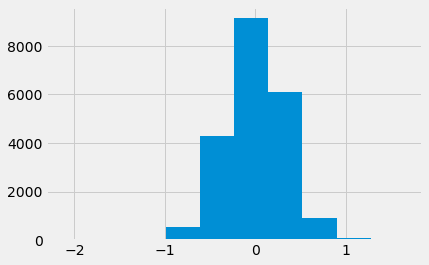

In [29]:
plt.hist(stepped_model.resid)
plt.show()

In [30]:
# to_scatter = X_hot.iloc[:,0:12].drop(['view','condition','floors','waterfront','yr_renovated'],axis=1)
# scatter_y  = pd.concat([y_log,to_scatter],axis=1)
# pd.plotting.scatter_matrix(scatter_y,figsize=(10,10))
# plt.tight_layout()
# plt.show()

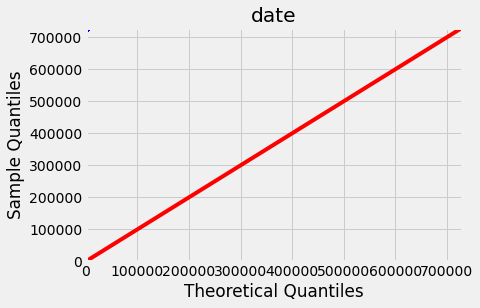

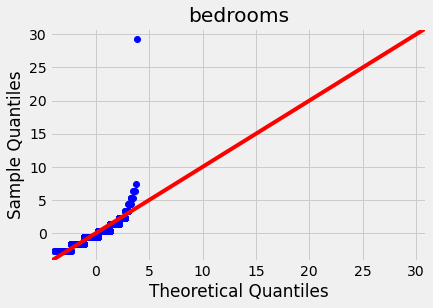

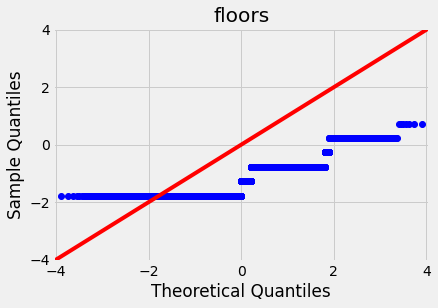

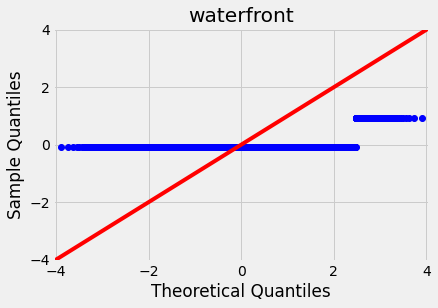

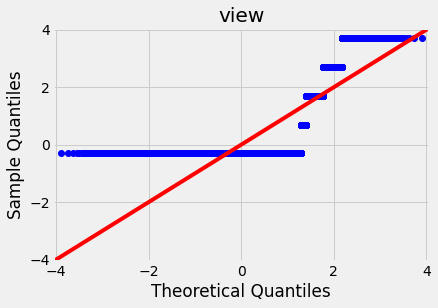

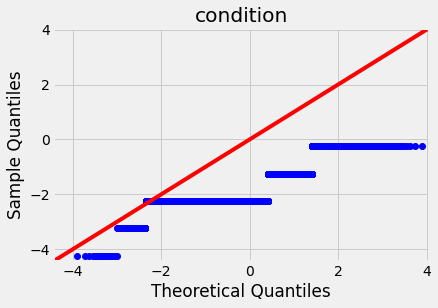

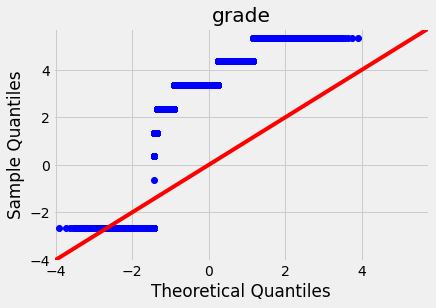

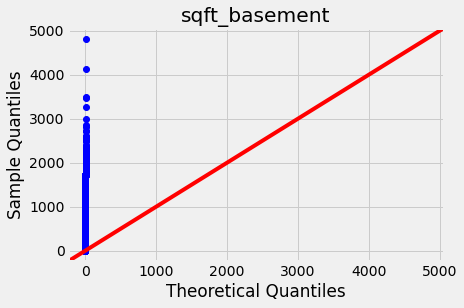

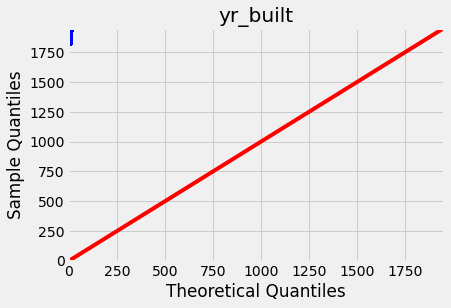

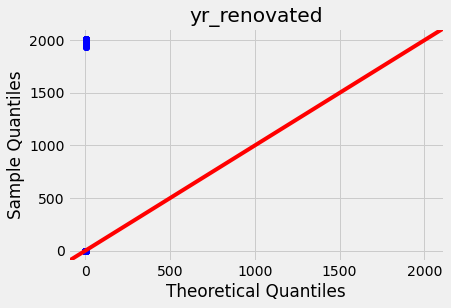

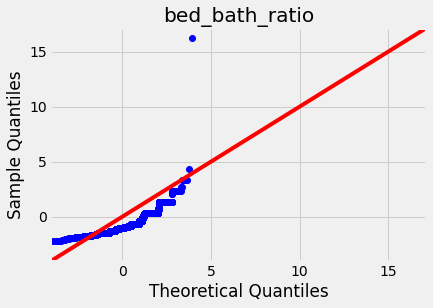

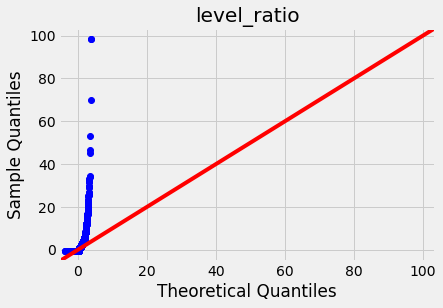

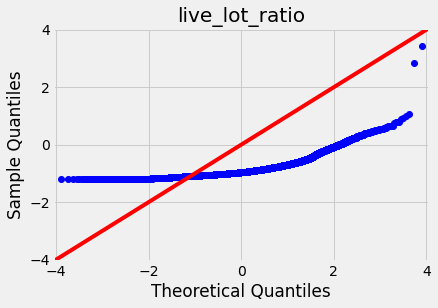

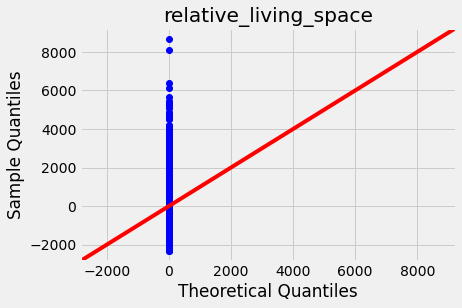

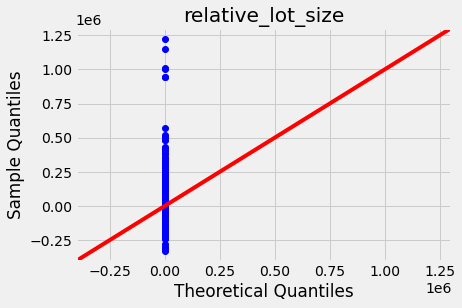

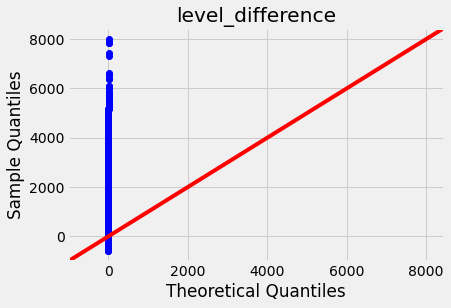

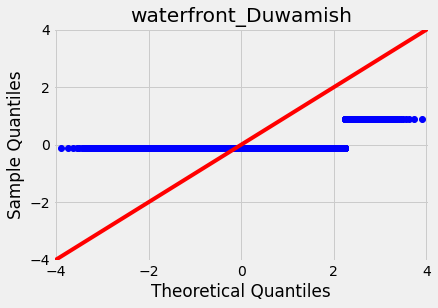

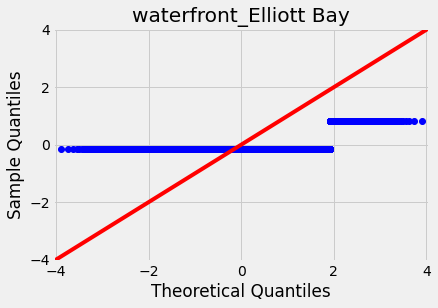

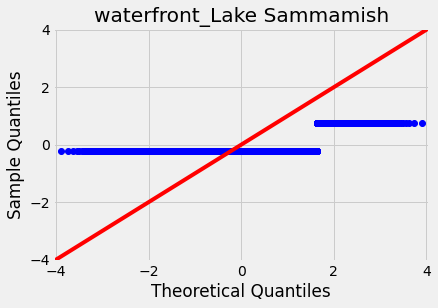

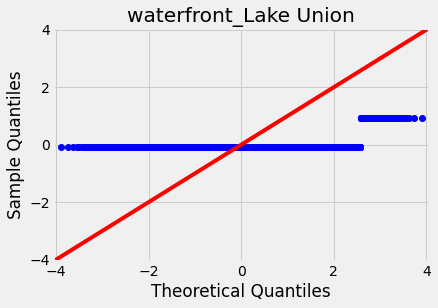

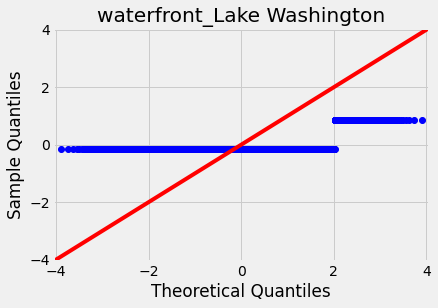

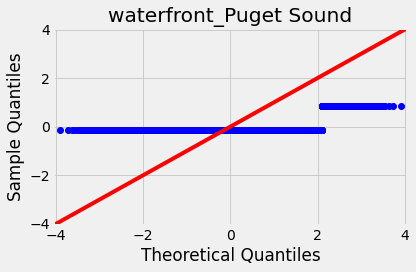

In [31]:
# Q-Q plots 

for feature in X_standardized.columns:
    sm.qqplot(X_standardized[feature], line ='45')
    plt.title(feature)

plt.tight_layout()
plt.show()

Recursive elimation: with and without cross-validation
- does not produce better results than stepwise selection

In [32]:
selected, ranking = run_RFECV(X_hot,y_log) # same results as stepwise selection model
RFECV_df = X_hot[selected]

# also identtical to baseline 
rfe_model = run_OLS_model(RFECV_df,y_log)
rfe_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     1765.
Date:                Sun, 27 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:18:42   Log-Likelihood:                -6054.9
No. Observations:               21143   AIC:                         1.215e+04
Df Residuals:                   21122   BIC:                         1.232e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -74.7306     14.465     -5.166      0.000    -103.083     -46.378
date                           0.0001   1.97e-05      6.590      0.000     9.1e-05       0.000
floors                         0.0410      0.007      5.976      0.000       0.028       0.054
waterfront                     0.3901      0.030     13.217      0.000       0.332       0.448
view                           0.0589      0.003     17.398      0.000       0.052       0.066
condition                      0.0512      0.004     13.575      0.000       0.044       0.059
sqft_basement                  0.0009   8.76e-06    105.180      0.000       0.001       0.001
yr_built                      -0.0044      0.000    -42.657      0.000      -0.005      -0.004
yr_renovated                3.397e-05   6.43e-06      5.281      0.000    2.14e-05    4.66e-05
bed_bath_ratio                -0.0683      0.004    -17.207      0.000      -0.076      -0.061
level_ratio                    0.0083      0.001      8.980      0.000       0.006       0.010
live_lot_ratio                 0.3475      0.012     29.655      0.000       0.325       0.371
relative_living_space         -0.0002   5.34e-06    -38.544      0.000      -0.000      -0.000
relative_lot_size           4.973e-07   7.83e-08      6.353      0.000    3.44e-07    6.51e-07
level_difference               0.0005   4.31e-06    112.080      0.000       0.000       0.000
waterfront_Duwamish           -0.3692      0.020    -18.233      0.000      -0.409      -0.329
waterfront_Elliott Bay         0.1541      0.014     11.218      0.000       0.127       0.181
waterfront_Lake Sammamish      0.1458      0.010     13.983      0.000       0.125       0.166
waterfront_Lake Union          0.2910      0.032      9.134      0.000       0.229       0.353
waterfront_Lake Washington     0.0937      0.015      6.067      0.000       0.063       0.124
waterfront_Puget Sound        -0.2082      0.017    -12.356      0.000      -0.241      -0.175
==============================================================================
Omnibus:                      102.221   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.333
Skew:                          -0.042   Prob(JB):                     2.04e-31
Kurtosis:                       3.392   Cond. No.                     4.80e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.8e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

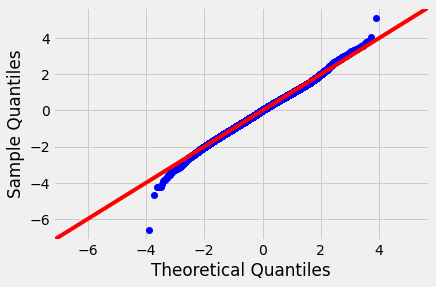

In [33]:
resid = stepped_model.resid
fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)

In [34]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(resid)
list(zip(name, test))

[('Jarque-Bera', 141.33279426239122),
 ('Prob', 2.041614163550048e-31),
 ('Skew', -0.04202271229383),
 ('Kurtosis', 3.3916211219131096)]

Concat X_hot with predictor and export as CSV for use in diagnosis and validation notebook.

In [37]:
export_df = pd.concat([y,X_hot],axis=1)

In [39]:

# from pathlib import Path  
# filepath = Path('data/base_model.csv')  
# filepath.parent.mkdir(parents=True, exist_ok=True)  
# export_df.to_csv(filepath,index=False)